# Model Interpretability: SHAP

In [1]:
# Obviously
import pandas as pd
import numpy as np

# Some sklearn tools for preprocessing.
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Our algorithms, by from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier

### The Dataset

In [2]:
# Load data and create lists of numerical and categorical features

df = pd.read_csv("data/bank.csv")

# Get X, y
y = df["y"].map({"no": 0, "yes": 1})
X = df.drop("y", axis=1)

num_features = ["age", "campaign", "pdays", "previous"]

cat_features = ["job", "marital", "education","default", "housing", "loan", "contact", 
                "month", "day_of_week", "poutcome"]

Description of features:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
12. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
13. previous: number of contacts performed before this campaign and for this client (numeric)
14. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

In [3]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

Let's create a preprocessor as before, and use the same gymnastics to get nice name for our new dummy features. 
Here we'll keep both the raw data `X_train` and processed one `X_train_processed` as we will need both of them for LIME.

In [4]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

In [5]:
# Train preprocessor
preprocessor.fit(X_train)

# Get the list of categories generated by the process
ohe_categories = preprocessor.named_transformers_["categorical"].categories_

# Create nice names for our one hot encoded features
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]

# Create a new list with all names of features
all_features = num_features + new_ohe_features

# Save processed data
X_train_processed = pd.DataFrame(preprocessor.transform(X_train), columns=all_features)
X_test_processed = pd.DataFrame(preprocessor.transform(X_test), columns=all_features)

### The models

Since we've tuned and trained the models in the previous notebook, here we'll just do everything at once so we can focus on interpreting them.

In [6]:
# Logistic Regression
lr_model = LogisticRegression(C=1.3, class_weight="balanced", solver="liblinear", random_state=42)
lr_model.fit(X_train_processed, y_train)

# Decision Tree
dt_model = DecisionTreeClassifier(class_weight="balanced", max_depth=10, min_samples_split=.01)
dt_model.fit(X_train_processed, y_train)

# Random Forest
rf_model = RandomForestClassifier(class_weight="balanced", n_estimators=150, n_jobs=-1, 
                                                      min_samples_split=.01, max_depth=15)
rf_model.fit(X_train_processed, y_train)

# LightGBM
lgb_model = LGBMClassifier(class_weight="balanced", n_jobs=-1, 
                                              max_depth=10, min_child_samples=40, n_estimators=50)
lgb_model.fit(X_train_processed, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(class_weight='balanced', max_depth=10, min_child_samples=40,
               n_estimators=50)

## SHAP to interpret local predictions

In [11]:
#! pip install shap

In [12]:
import shap
# Need to load JS vis in the notebook
shap.initjs() 

SHAP has a generic explainer that works for any model, called `KernelExplainer`. This explainer requires an arbitrary model and some training data in order to calibrate itself. This fully agnostic method is slow and only computes an approximation of the SHAP values, so `shap` also provides special explainers that are optimised for specific classes of models. The `TreeExplainer` is optimised for tree based models, and is what we will use here with our LGB model (the hardest to intepret). 

`TreeExplainer` also has the advantage that it can "calibrate" itself using properties of trees directly, instead of estimating values from an external dataset, that means that we only need to provide a model and `shap` does the rest.

To get started, you need to create a SHAP explainer object from your model. 

Create a new explainer using `shap.TreeExplainer`, here you can directly pass your model stored inside the `lgb_model` pipeline:

In [13]:
explainer = shap.TreeExplainer(lgb_model)


Now that we have an explainer object, we can start using it to compute SHAP values on our data. Here we're interested in explaining specific predictions, let's choose a row in our test set first:

In [18]:
i = 4

observation = X_test_processed.iloc[[i]]
print(f"Observation true label: {y_test.iloc[i]}")
print(f"Observation predicted label (proba): {lgb_model.predict_proba(observation)[:,1]}")

observation

Observation true label: 1
Observation predicted label (proba): [0.89370749]


,age,campaign,pdays,previous,job__admin.,job__blue-collar,job__entrepreneur,job__housemaid,job__management,job__retired,...,month__oct,month__sep,day_of_week__fri,day_of_week__mon,day_of_week__thu,day_of_week__tue,day_of_week__wed,poutcome__failure,poutcome__nonexistent,poutcome__success
4,27.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


The observation we selected corresponds to a 27 years old prospect that ended up subscribing to our plan, and our model predicted that outcome with a probability of .89, not bad! 

The first step for interpretation is to compute SHAP values for this observation. SHAP values are a way to know the contribution of each specific attribute of the observation in the final prediction: for instance, how much of an impact the fact that the prospect is 27 had on our prediction?  What about the fact that they were called on a Wednesday? etc...

To compute SHAP value, you can use the method `shap_values` from your model explainer and pass your observation. Do so and call the output `shap_values`:

In [101]:
shap_values = explainer.shap_values(observation)


Check the dimension of the returned matrix:

In [102]:
shap_values

[array([[-1.15818389e-01,  2.29928720e-01, -1.46586051e+00,
         -2.56420927e-02,  4.28697235e-03, -1.55632365e-02,
          2.28538116e-04, -1.16227932e-03,  4.38232361e-04,
          2.85138723e-03, -3.55056368e-06, -4.11366257e-03,
          1.24098787e-03,  1.48348650e-02,  5.97063194e-04,
         -6.57333630e-02, -3.84401951e-04, -3.69787225e-03,
         -1.36220284e-02,  0.00000000e+00, -9.41927303e-03,
          9.87569073e-04, -9.55925746e-04, -8.83995046e-03,
          0.00000000e+00, -1.58999879e-03, -3.40471694e-02,
          1.74911324e-03, -4.80274399e-02,  0.00000000e+00,
          0.00000000e+00,  6.10687625e-03, -1.11782485e-03,
          1.17114869e-02,  1.29236457e-04,  0.00000000e+00,
          5.63651933e-04, -2.16299782e-01,  7.09454177e-05,
          1.09666456e-02,  2.23825484e-03,  1.94533051e-03,
         -2.34444060e-03, -4.28683023e-01,  9.47357525e-03,
         -6.35911072e-02, -1.07619648e-02,  2.53285331e-03,
          5.28156784e-03,  9.57412987e-0

For binary classification, `shap_values` returns a single numpy array with the SHAP value associated to each of the features. For our given observation, SHAP value per feature can be positive or negative, and if we sum them we get the difference between the value our model predicted and its "expected value".

If you use the model agnostic `KernelExplainer`, those values will be expressed as probabilities. With the `TreeExplainer` though, the unit will be specific to the library/model you are using. For lightbm's classifier that is `log_odds`. let's do some sanity check!

In [103]:
# If you need to check in what unit the output is, run the following:
explainer.model.tree_output

'log_odds'

Let's start with the `expected_value`: it corresponds to the average output of our model, here it will be expressed as a log_odds of the predictions of our models on the training set:

In [104]:
def average_log_odds(predictions):
    return np.mean(np.log(predictions / (1 - predictions)))

With `lgb_model`, generate predictions from the training data and compute the average log odds using the function above (don't forget to get the prediction for class 1 only -- predict_proba will return two values per row)

In [105]:
y_pred = lgb_model.predict_proba(X_train_processed)
average_log_odds(y_pred[:, 1])

-0.44953180992367575

Check that it is equal to your explainer's `expected_value`:

In [106]:
explainer.expected_value


[0.4495318099236759, -0.4495318099236759]

Great, now we can compute the difference between our model's prediction for this specific observation (it needs to be expressed as a log_odd) and the expected value: this difference is what `shap` is aiming to explain through SHAP values:

In [107]:
# Compute the difference between your model's prediction on the observation and the expected value
average_log_odds(lgb_model.predict_proba(observation)[:, 1]) - explainer.expected_value


array([1.67965193, 2.57871555])

Verify that this matches the sum of your SHAP values:

In [108]:
np.sum(shap_values)


2.7755575615628914e-16

`shap` implements a `force_plot` function that allows to nicely plot the shap values for our observation, call `force_plot` passing:
- your model's `expected_value`
- your observation's `shap_values`
- your observation (the row)

By default this will plot shap_values as log_odds, but you can display them as probabilities by passing `link="logit"`

In [109]:
shap.force_plot(explainer.expected_value[1], shap_values[1], features=observation, link="logit")


This plot makes it easier to see the impact of each feature. Here the base value (equivalent of the expected value) is at 0.39 (most people did not subscribe to a plan so this is the most likely outcome) whilst our model predicted 0.90 chance of the person subscribing.

In pink we see the features that justifies this shift from base value to output value: the fact that the prospect was contacted 3 days after the previous campaign seems to have the highest impact (a contribution of about 0.20), the month being June also seems to have a positive impact. In blue, only one feature is impacting the prediction in the other direction, the fact that this person was contacted 4 times.

With this tool at hand, we can now go back to the marketing team and explain what our model seems to look at here to make predictions, it would be interesting to compare with what they think might have happened. A few questions that we might have:
- Did something special happened in June -- is our model consistently picking June as an explanation for successful campaigns?
- Why is pdays=3 important? Would it be better with a bit more days? A bit less?
- What's wrong with having contacted the person 4 times? 
- Can pdays and campaign be linked? Or maybe linked to other features in the data (different demographics might prefer more or less pushy campaigns)?

The marketing team can probably help with some of those questions, but in the meantime, we can investigate further by investigating our model at a global scale instead of local. `shap` provides efficient techniques to do so!

## SHAP for global interpretation of a model

If we compute SHAP values for multiple observations at a time, `shap` is able to plot them with `force_plot` in a similar way as above, but for all at once, let's take a look. First select 1000 observations at random from the test set, call the resulting dataframe `observations`:

In [110]:
observations = X_test_processed.sample(1000, random_state=42)
observations

,age,campaign,pdays,previous,job__admin.,job__blue-collar,job__entrepreneur,job__housemaid,job__management,job__retired,...,month__oct,month__sep,day_of_week__fri,day_of_week__mon,day_of_week__thu,day_of_week__tue,day_of_week__wed,poutcome__failure,poutcome__nonexistent,poutcome__success
7642,34.0,1.0,999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9445,57.0,1.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7879,49.0,1.0,999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
11479,64.0,2.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6730,50.0,2.0,999.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,48.0,1.0,999.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
12045,38.0,3.0,999.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2452,57.0,1.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
217,36.0,4.0,999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Use our explainer (same as before, calibrated on our `lgb_model`) to compute SHAP values for our observations:

In [111]:
shap_values = explainer.shap_values(observations)
shap_values

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[array([[ 5.35400167e-02, -6.76864324e-02,  9.50781693e-02, ...,
          1.34777378e-03, -1.09391154e-03,  1.26666226e-02],
        [ 2.68110769e-02, -8.24353762e-02,  9.60512608e-02, ...,
         -2.30127345e-03, -1.11814503e-04,  1.29208283e-02],
        [ 9.02829761e-02, -6.05381767e-02,  1.12909200e-01, ...,
         -1.34203873e-03, -2.95857443e-04,  8.06882565e-03],
        ...,
        [ 1.74410426e-02, -6.88926287e-02,  1.10531360e-01, ...,
         -1.28086110e-03, -3.83405835e-04,  7.73202232e-03],
        [ 7.71711324e-02, -1.08267039e-02,  9.38484454e-02, ...,
         -6.39318220e-04, -1.30923119e-04,  1.30560161e-02],
        [ 7.54129360e-02, -6.43991383e-02,  1.10719838e-01, ...,
         -1.47286117e-03, -2.95857443e-04,  7.72357415e-03]]),
 array([[-5.35400167e-02,  6.76864324e-02, -9.50781693e-02, ...,
         -1.34777378e-03,  1.09391154e-03, -1.26666226e-02],
        [-2.68110769e-02,  8.24353762e-02, -9.60512608e-02, ...,
          2.30127345e-03,  1.11814503e

Use `force_plot` again, but this time passing all shapley values and all observations:

In [112]:
shap.force_plot(explainer.expected_value[1], shap_values[1], features=observations, link="logit")


We can see our 1000 samples on the x-axis. The y-axis corresponds to the same scale we were looking at before, where blue values corresponds to the probability decreasing, red increasing. 

By default our observations our sorted by similarity, we can see on the left a group of samples which have a high probability of subscribing to the plan and for which `pdays` have a high impact (large pink area -- you can hover with your mouse to see the details). In the center we have a majority of samples around 50% chance of either subscribing or not and with feature such as the month, cellular and default being important. Then on the right we can see samples that have a really low probability of subscribing to our plan.

You can use the dropdown at the top to sort the samples by a specific feature, try to sort them by `pdays`, what do you observe? If it is hard to see with all shap values displayed, you can filter to keep only pdays related shap values using the dropdown on the left.

It looks like smaller values of pdays have a large positive impact on the probability of subscribing, whilst larger values seem less relevant or even have a negative impact.

Can you do the same with `campaign` and `age`, what do you observe?

Using `force_plot` on multiple SHAP values is really powerful, but still requires to go through features one by one to understand the model. `shap` provides another plot, the `summary_plot` that can be seen as an overall feature importance plot with extra information about the way each feature impacts outcomes.

Use `summary_plot` passing your subset of SHAP values and observations:

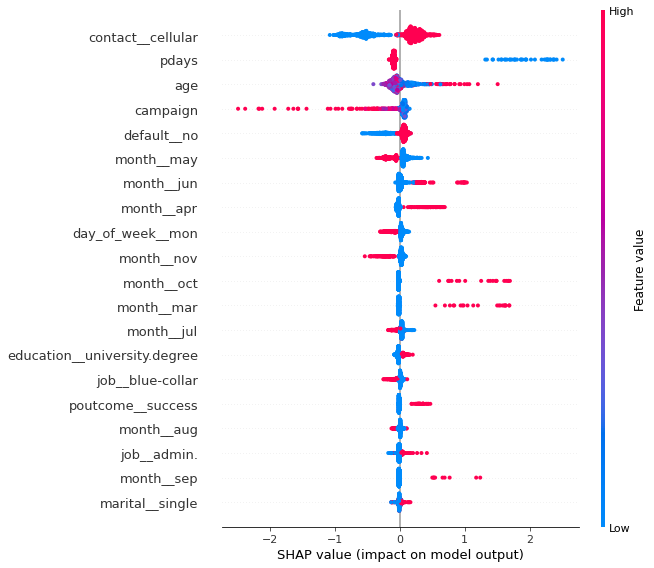

In [113]:
shap.summary_plot(shap_values[1], features=observations)


Here each point corresponds to a SHAP value for a given feature for a given samples. Features are grouped on the y-axis and the x-axis represent the SHAP value, either negative or positive. The colour correspond to the value of the feature, either high or low.

For example, `contact_cellular` will be red if 1 and blue if 0. Here it looks like for people that have been contacted by phone (contact_cellular==1==red), this has contributed positively to their chance of subscribing, whilst not having a phone contributed negatively (blue dots on the left side). The impact is fairly low on both sides though, between -1 and 1.

`pdays` is interesting too, here high values (red) of pdays seem to have a small negative impact on the predictions, but a low value, a couple of days has a really high positive impact (that's what we've observed multiple times already).

`campaign` has an opposite behaviour: a really large negative impact for high values (when prospects are called too many times).

We can find interesting information about months as well, it looks like October and March have quite high impact for some predictions in red (value==1), whilst month like July don't seem to matter much. 

Finally, `shap` also implements a way to plot SHAP values as interaction between two features. 

Call `dependence_plot` on the feature `age`. You will need to pass your shap_values and observations.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


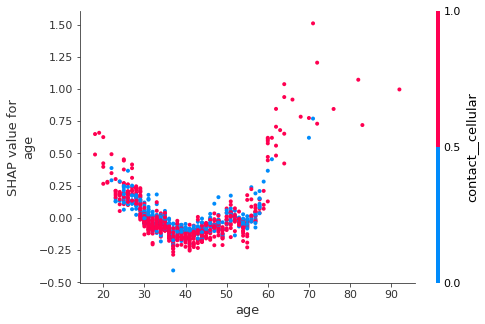

In [116]:
shap.dependence_plot("age", shap_values=shap_values[1], features=observations)

We can see again that age seems to have a high impact for the youngest and oldest prospects but not as much in between. `dependence_plot` automatically picked a feature that was correlated with `age` to be the dependent one here, but this can be changed by setting  `interaction_index` to any other features you want.

Try multiple combinations of features, and try to make sense of what you observe.

`shap` is really powerful and allows to understand your model both locally and globally. 

A word of warning though, it can get extremely slow to compute SHAP values using the model-agnostic KernelExplainer. That means that if your model is tree based (tree explainer), neural networks (deep explainer) or linear, you'll be able to get the best out of `shap` with good performance. But for other models, such as KNN, SVM or even a custom sklearn Pipeline object allowing you to work with categorical features directly instead of dummies, you will have to either use the slow `KernelExplainer` or prefer other more approximative techniques such as LIME for local explanations or permutation importance for global ones.